# Instruction to `lfi`

This notebook will introduce you to  `lfi`, a python package implemented in our paper (removed for submission). See the Github page (removed for submission) for instructions.

In [1]:
import sys, os, inspect
sys.path.append('..')
import lfi
import numpy as np
import matplotlib.pyplot as plt
import torch
from IPython.display import clear_output
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## A simple example

### Prepare data

As a simple example, let us consider a two-dimensional example where $P_X$, $P_Y$ are 2-dimensional Gaussians $\mathcal{N}((0,0),I)$, $\mathcal{N}((0.5,0),I)$.

In [2]:
mean_X = np.array([0, 0])
mean_Y = np.array([0.5, 0])

Set $n_{tr},n_{cal},n_{ev}$

In [3]:
n_tr = 1000
n_ev = 1000
n_cal = 1000

In [4]:
X_tr = mean_X + np.random.randn(n_tr, 2)
Y_tr = mean_Y + np.random.randn(n_tr, 2)
X_ev = mean_X + np.random.randn(n_ev, 2)
Y_ev = mean_Y + np.random.randn(n_ev, 2)
X_cal = mean_X + np.random.randn(n_cal, 2)
Y_cal = mean_Y + np.random.randn(n_cal, 2)

In [5]:
X_cal = torch.tensor(X_cal, device=device)
Y_cal = torch.tensor(Y_cal, device=device)
X_ev = torch.tensor(X_ev, device=device)
Y_ev = torch.tensor(Y_ev, device=device)
X_tr = torch.tensor(X_tr, device=device)
Y_tr = torch.tensor(Y_tr, device=device)

### Prepare kernel

Let the kernel be an isotropic Gaussian kernel with a trainable bandwidth. We should define a class named `Model` inherits from `torch.nn.Module`. `Model` must contain the following functions:
1. \_\_init\_\_(self, device, **kwargs): 
    - device is where the model should stored.
    - self.params must be initialized as trainable parameters here.
2. com-ute_loss(self, XY_tr, **kwargs):
    - XY_tr.shape=(2*batch_size, dim), should return the loss function for training
3. compute_scores(self, X_ev, Y_ev, Z_input):
    - X_ev.shape=Y_ev.shape=(n_ev,dim) and Z_input.shape=(n_z;dim). return the witness function. 
4. compute_gamma(self, X_ev, Y_ev, Z_input):
    - compute the $\gamma(X_{ev},Y_{ev})$ in our paper.

In [6]:
class Model(torch.nn.Module):
    def __init__(self, device, **kwargs):
        super(Model, self).__init__()
        self.device = device
        self.sigma = torch.ones(1, requires_grad=True, device=self.device)
        self.params = [self.sigma]
            
    def compute_loss(self, XY_tr, **kwargs):
        X_tr = XY_tr[:XY_tr.shape[0]//2]
        Y_tr = XY_tr[XY_tr.shape[0]//2:]
        Kxx = torch.exp(-(lfi.utils.Pdist2(X_tr,X_tr)/self.sigma**2))
        Kyy = torch.exp(-(lfi.utils.Pdist2(Y_tr,Y_tr)/self.sigma**2))
        Kxy = torch.exp(-(lfi.utils.Pdist2(X_tr,Y_tr)/self.sigma**2))
        mmd_val, mmd_var = lfi.utils.h1_mean_var_gram(Kxx, Kyy, Kxy, True)
        STAT_u = mmd_val / torch.sqrt(mmd_var+10**(-8)) 
        return -STAT_u
    
    def compute_scores(self, X_ev, Y_ev, Z_input):
        Kxz = torch.exp(-(lfi.utils.Pdist2(X_ev,Z_input)/self.sigma**2))
        Kyz = torch.exp(-(lfi.utils.Pdist2(Y_ev,Z_input)/self.sigma**2))
        phi_Z = torch.mean(Kyz,0) - torch.mean(Kxz,0)
        return phi_Z

    def compute_gamma(self, X_ev, Y_ev, pi):
        batch_size = X_ev.shape[0]
        Kxx = torch.exp(-(lfi.utils.Pdist2(X_ev,X_ev)/self.sigma**2))
        Kyy = torch.exp(-(lfi.utils.Pdist2(Y_ev,Y_ev)/self.sigma**2))
        Kxy = torch.exp(-(lfi.utils.Pdist2(X_ev,Y_ev)/self.sigma**2))
        EKxx = (torch.sum(Kxx) - torch.sum(torch.diag(Kxx)))/ (batch_size * (batch_size - 1))
        EKyy = (torch.sum(Kyy) - torch.sum(torch.diag(Kyy)))/ (batch_size * (batch_size - 1))
        EKxy = torch.sum(Kxy) / (batch_size * batch_size)
        gamma = EKxx*(pi/2-1) + EKxy*(1-pi) + EKyy*(pi/2)
        return gamma

In [7]:
kernel = Model(device)

### Train the kernel

Then we train the model. Choose 10% of $X_{tr}, Y_{tr}$ to be the validation set.

In [8]:
n_validation = 0.1*n_tr
X_validate = X_tr[:int(n_validation)]
Y_validate = Y_tr[:int(n_validation)]

Create training set and validation set

In [9]:
S_validate = torch.cat([X_validate, Y_validate]).to(device)
XY_tr = torch.cat((X_tr, Y_tr)).to(device)
train_loader = torch.utils.data.DataLoader([XY_tr], batch_size=1, shuffle=True)

Setup the training

In [10]:
optimizer = torch.optim.Adam(kernel.params, lr=0.1) # optimizer 
N_epoch = 100 # the maximum number of epochs
ckpt_dir = './checkpoints' # directory to save the checkpoints
patience = 10 # we stop training once the validation loss does not improve for 10 epochs
save_every = 100 # save the model every 10 epoch

Start training

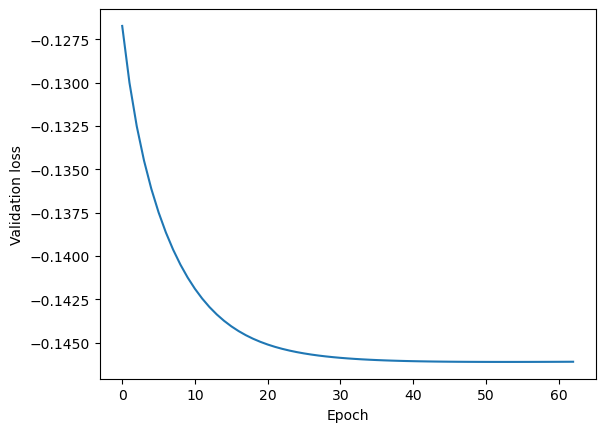

In [11]:
kernel, validation_loss_epoch_records = lfi.train.train(n_tr, train_loader, S_validate, 
                                                        kernel, optimizer, N_epoch, 
                                                        save_every, ckpt_dir, patience, verbose=False)
clear_output()
plt.plot(validation_loss_epoch_records)
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.show()

### Test

Suppose we have $Z$ sampled from $0.1P_X+0.9P_Y$ with size $m$

In [12]:
m = 100
tem = np.random.binomial(m, 0.1)
Z = np.concatenate((mean_X + np.random.randn(tem, 2), mean_Y + np.random.randn(m-tem, 2)), axis=0)
Z = torch.tensor(Z, device=device)

The p value is calculated via Gaussian approximation (as explained in paper)

In [13]:
p, wit_Z = lfi.test.get_estimated_pval(kernel, X_cal, Y_cal, X_ev, Y_ev, Z=Z)
print('Estimated p-value: %.2fσ'%p.item())

Estimated p-value: 5.14σ


We can also perform the test (4) in our paper

In [15]:
print('Z is classified to H%d'%(wit_Z > kernel.compute_gamma(X_ev, Y_ev, 0.1)))

Z is classifies to H1
